# Training with ImageDataGenerator

Build a train a model on the **Horses or Humans dataset**. This contains over a thousand images of horses and humans with varying poses and filesizes. Use the *ImageDataGenerator* class to prepare this dataset so it can be fed to a convolutional neural network.

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2023-08-06 05:55:18--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  84.2MB/s    in 1.7s    

2023-08-06 05:55:20 (84.2 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

In [3]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:5])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:5])

['horse14-9.png', 'horse36-9.png', 'horse17-3.png', 'horse24-3.png', 'horse26-9.png']
['human05-26.png', 'human10-26.png', 'human04-11.png', 'human14-13.png', 'human02-25.png']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

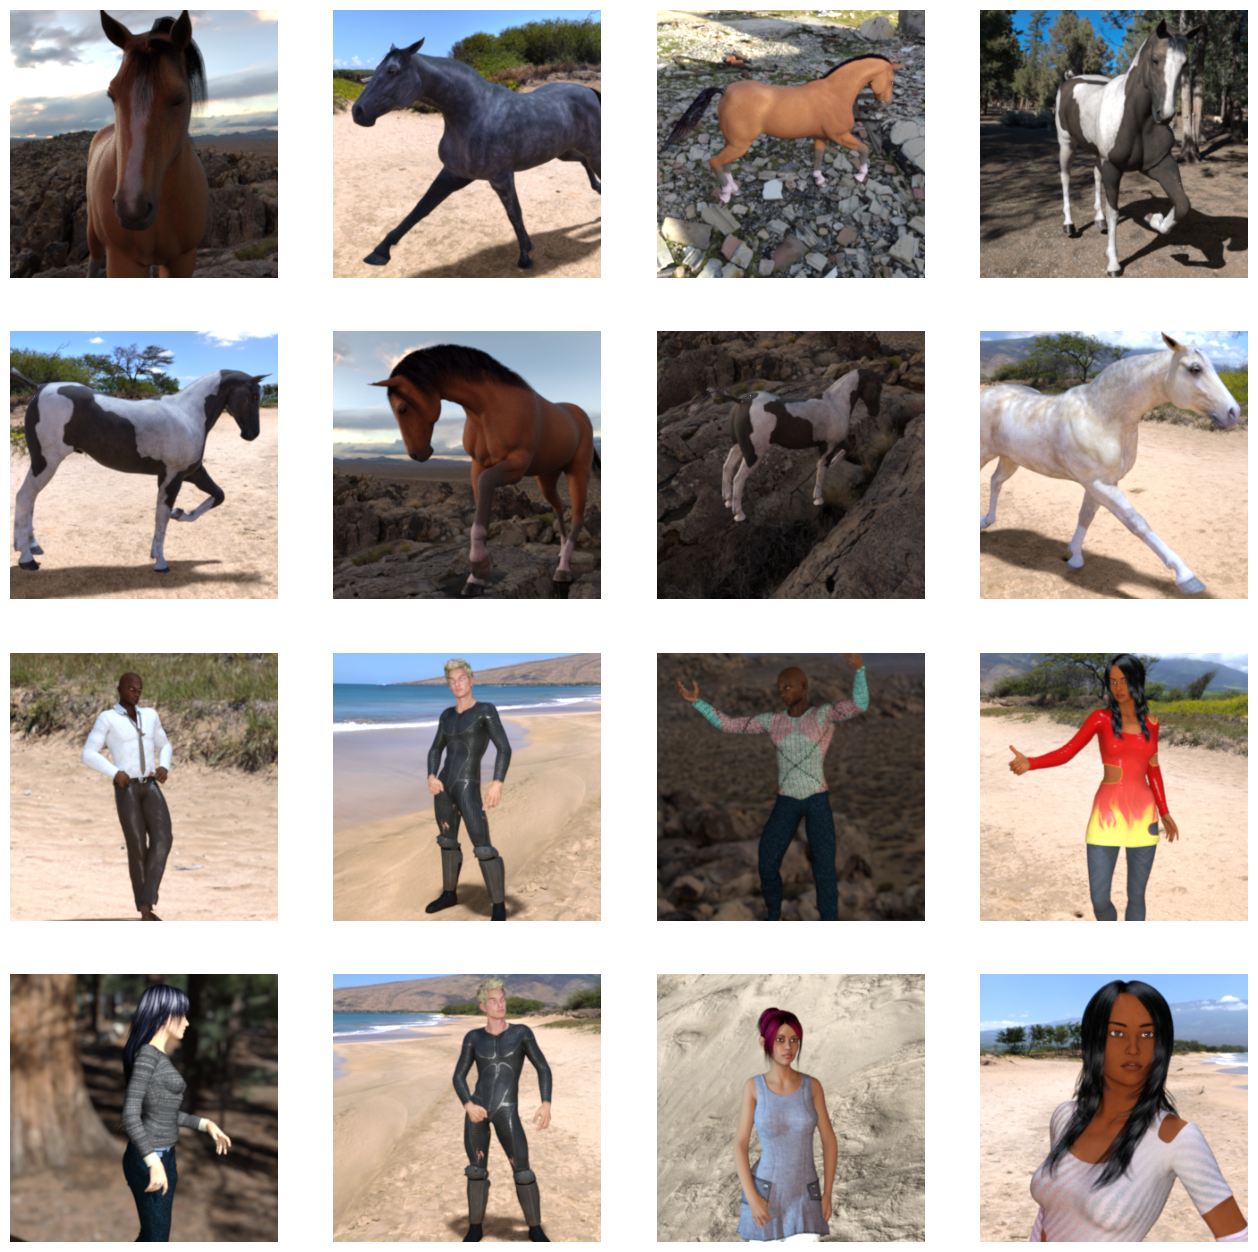

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

In [7]:
import tensorflow as tf

In [8]:
model = tf.keras.models.Sequential([
    # Input shape is the desired size of the image 300x300 with 3 bytes color

    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

## Data Preprocessing

Set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

It is uncommon to feed raw pixels into a ConvNet. In this case, you will preprocess the images by normalizing the pixel values to be in the range `[0,1]`.

 This can be done via the `keras.preprocessing.image`. `ImageDataGenerator` class using the rescale parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


## Training

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 22s 860ms/step - loss: 1.1167 - accuracy: 0.5417
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 0.6935 - accuracy: 0.5139
Epoch 3/15
8/8 [==============================] - 7s 884ms/step - loss: 0.6695 - accuracy: 0.5395
Epoch 4/15
8/8 [==============================] - 7s 933ms/step - loss: 0.6477 - accuracy: 0.6618
Epoch 5/15
8/8 [==============================] - 7s 949ms/step - loss: 1.0137 - accuracy: 0.8065
Epoch 6/15
8/8 [==============================] - 8s 1s/step - loss: 0.3816 - accuracy: 0.8525
Epoch 7/15
8/8 [==============================] - 7s 859ms/step - loss: 0.2392 - accuracy: 0.9077
Epoch 8/15
8/8 [==============================] - 7s 784ms/step - loss: 0.4347 - accuracy: 0.8476
Epoch 9/15
8/8 [==============================] - 7s 885ms/step - loss: 0.6183 - accuracy: 0.8409
Epoch 10/15
8/8 [==============================] - 8s 960ms/step - loss: 0.2065 - accuracy: 0.9336
Epoch 11/15
8/8 [=======

## Predictions

In [14]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving depositphotos_214783722-stock-photo-selective-focus-beautiful-brown-horse.jpg to depositphotos_214783722-stock-photo-selective-focus-beautiful-brown-horse.jpg
Saving depositphotos_335048212-stock-photo-young-caucasian-woman-isolated-who.jpg to depositphotos_335048212-stock-photo-young-caucasian-woman-isolated-who (1).jpg
1/1 [==============================] - 0s 19ms/step
[1.4792643e-14]
depositphotos_214783722-stock-photo-selective-focus-beautiful-brown-horse.jpg is a horse
1/1 [==============================] - 0s 23ms/step
[0.9999999]
depositphotos_335048212-stock-photo-young-caucasian-woman-isolated-who (1).jpg is a human
